Welcome to the 2025 Kaggle Playground Series! We plan to continue in the spirit of previous playgrounds, providing interesting and approachable datasets for our community to practice their machine learning skills, and anticipate a competition each month.

Your Goal: Predict the likelihood of accidents on different types of roads.

For this Playground Series challenge, we have teamed up with Stack Overflow to give you a two-part challenge. The Stack Overflow Challenge is the second part and builds upon this one by having participants develop a web application. We encourage you to check out the Stack Overflow Challenge!

If you complete both challenges, we’ll recognize your breadth of skills with a special “Code Scientist” badge which will appear on both Kaggle and Stack Overflow.

# Dataset Description

The dataset for this competition (both train and test) was generated from a deep learning model trained on the Simulated Roads Accident dataset. Feature distributions are close to, but not exactly the same, as the original. Feel free to use the original dataset as part of this competition, both to explore differences as well as to see whether incorporating the original in training improves model performance.

In [1]:
import pandas as pd 
import numpy as np


In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')

In [3]:
# Basic dataset information
print("Training set shape:", train.shape)
print("Test set shape:", test.shape)
print("\nTraining set info:")
print(train.info())
print("\nTest set info:")
print(test.info())


Training set shape: (517754, 14)
Test set shape: (172585, 13)

Training set info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517754 entries, 0 to 517753
Data columns (total 14 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   id                      517754 non-null  int64  
 1   road_type               517754 non-null  object 
 2   num_lanes               517754 non-null  int64  
 3   curvature               517754 non-null  float64
 4   speed_limit             517754 non-null  int64  
 5   lighting                517754 non-null  object 
 6   weather                 517754 non-null  object 
 7   road_signs_present      517754 non-null  bool   
 8   public_road             517754 non-null  bool   
 9   time_of_day             517754 non-null  object 
 10  holiday                 517754 non-null  bool   
 11  school_season           517754 non-null  bool   
 12  num_reported_accidents  517754 non-null  int64

In [4]:
# Função de pré-processamento baseada nas análises
def preprocess_data(df):
    """
    Aplica pré-processamento baseado nas análises:
    - num_reported_accidents: agrupa valores 1 e 2
    - speed_limit: categoriza em high (>=60) e low (<60)
    - curvature: cria bins (low, medium, high)
    - num_lanes: converte para string
    """
    df_processed = df.copy()
    
    # Agrupar num_reported_accidents: 1 e 2 viram 1
    mask = (df_processed['num_reported_accidents'] == 1) | (df_processed['num_reported_accidents'] == 2)
    df_processed.loc[mask, 'num_reported_accidents'] = 1
    
    # Categorizar speed_limit
    df_processed.loc[df_processed['speed_limit'] >= 60, 'speed_category'] = 'high'
    df_processed.loc[df_processed['speed_limit'] < 60, 'speed_category'] = 'low'
    df_processed = df_processed.drop(columns=['speed_limit'])
    
    # Converter num_lanes para string
    df_processed['num_lanes'] = df_processed['num_lanes'].astype(str)
    
    # Criar bins para curvature
    df_processed['curvature_bin'] = pd.cut(df_processed['curvature'], 
                                          bins=[0, 0.3, 0.7, 1.0], 
                                          labels=['low', 'medium', 'high'])
    df_processed = df_processed.drop(columns=['curvature'])
    
    return df_processed

# Aplicar pré-processamento
print("Aplicando pré-processamento...")
train_processed = preprocess_data(train)
test_processed = preprocess_data(test)

print("Pré-processamento concluído!")
print(f"Train shape: {train_processed.shape}")
print(f"Test shape: {test_processed.shape}")
print(f"\nColunas do train: {list(train_processed.columns)}")
print(f"Colunas do test: {list(test_processed.columns)}")


Aplicando pré-processamento...
Pré-processamento concluído!
Train shape: (517754, 14)
Test shape: (172585, 13)

Colunas do train: ['id', 'road_type', 'num_lanes', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'accident_risk', 'speed_category', 'curvature_bin']
Colunas do test: ['id', 'road_type', 'num_lanes', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'speed_category', 'curvature_bin']


In [5]:
# Verificar as transformações aplicadas
print("=== VERIFICAÇÃO DAS TRANSFORMAÇÕES ===")

print("\n1. num_reported_accidents:")
print("Train original:", train['num_reported_accidents'].value_counts().sort_index())
print("Train processado:", train_processed['num_reported_accidents'].value_counts().sort_index())
print("Test processado:", test_processed['num_reported_accidents'].value_counts().sort_index())

print("\n2. speed_category (nova feature):")
print("Train:", train_processed['speed_category'].value_counts())
print("Test:", test_processed['speed_category'].value_counts())

print("\n3. curvature_bin (nova feature):")
print("Train:", train_processed['curvature_bin'].value_counts())
print("Test:", test_processed['curvature_bin'].value_counts())

print("\n4. num_lanes (convertido para string):")
print("Train:", train_processed['num_lanes'].value_counts().sort_index())
print("Test:", test_processed['num_lanes'].value_counts().sort_index())


=== VERIFICAÇÃO DAS TRANSFORMAÇÕES ===

1. num_reported_accidents:
Train original: num_reported_accidents
0    125269
1    209674
2    145965
3     34197
4      2392
5       231
6        24
7         2
Name: count, dtype: int64
Train processado: num_reported_accidents
0    125269
1    355639
3     34197
4      2392
5       231
6        24
7         2
Name: count, dtype: int64
Test processado: num_reported_accidents
0     42054
1    118340
3     11266
4       841
5        75
6         8
7         1
Name: count, dtype: int64

2. speed_category (nova feature):
Train: speed_category
low     328802
high    188952
Name: count, dtype: int64
Test: speed_category
low     109685
high     62900
Name: count, dtype: int64

3. curvature_bin (nova feature):
Train: curvature_bin
medium    234138
low       150383
high      131688
Name: count, dtype: int64
Test: curvature_bin
medium    78063
low       50574
high      43439
Name: count, dtype: int64

4. num_lanes (convertido para string):
Train: num_lane

In [6]:
# Preparar dados para modelagem
# Separar features e target
X_train = train_processed.drop(['id', 'accident_risk'], axis=1)
y_train = train_processed['accident_risk']
X_test = test_processed.drop(['id'], axis=1)

print("Dados preparados para modelagem:")
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")

print(f"\nFeatures finais: {list(X_train.columns)}")

# Verificar tipos de dados
print(f"\nTipos de dados:")
print(X_train.dtypes)


Dados preparados para modelagem:
X_train shape: (517754, 12)
y_train shape: (517754,)
X_test shape: (172585, 12)

Features finais: ['road_type', 'num_lanes', 'lighting', 'weather', 'road_signs_present', 'public_road', 'time_of_day', 'holiday', 'school_season', 'num_reported_accidents', 'speed_category', 'curvature_bin']

Tipos de dados:
road_type                   object
num_lanes                   object
lighting                    object
weather                     object
road_signs_present            bool
public_road                   bool
time_of_day                 object
holiday                       bool
school_season                 bool
num_reported_accidents       int64
speed_category              object
curvature_bin             category
dtype: object


In [7]:
# Encoding das variáveis categóricas
from sklearn.preprocessing import LabelEncoder

# Identificar colunas categóricas
categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day', 'speed_category', 'curvature_bin', 'num_lanes']
boolean_cols = ['road_signs_present', 'public_road', 'holiday', 'school_season']

print("Colunas categóricas:", categorical_cols)
print("Colunas booleanas:", boolean_cols)

# Aplicar LabelEncoder nas variáveis categóricas
label_encoders = {}
X_train_encoded = X_train.copy()
X_test_encoded = X_test.copy()

for col in categorical_cols:
    le = LabelEncoder()
    X_train_encoded[col] = le.fit_transform(X_train[col].astype(str))
    X_test_encoded[col] = le.transform(X_test[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {dict(zip(le.classes_, le.transform(le.classes_)))}")

print(f"\nDados após encoding:")
print(f"X_train_encoded shape: {X_train_encoded.shape}")
print(f"X_test_encoded shape: {X_test_encoded.shape}")
print(f"Tipos finais: {X_train_encoded.dtypes.value_counts()}")


Colunas categóricas: ['road_type', 'lighting', 'weather', 'time_of_day', 'speed_category', 'curvature_bin', 'num_lanes']
Colunas booleanas: ['road_signs_present', 'public_road', 'holiday', 'school_season']
road_type: {'highway': np.int64(0), 'rural': np.int64(1), 'urban': np.int64(2)}
lighting: {'daylight': np.int64(0), 'dim': np.int64(1), 'night': np.int64(2)}
weather: {'clear': np.int64(0), 'foggy': np.int64(1), 'rainy': np.int64(2)}
time_of_day: {'afternoon': np.int64(0), 'evening': np.int64(1), 'morning': np.int64(2)}
speed_category: {'high': np.int64(0), 'low': np.int64(1)}
curvature_bin: {'high': np.int64(0), 'low': np.int64(1), 'medium': np.int64(2), np.str_('nan'): np.int64(3)}
num_lanes: {'1': np.int64(0), '2': np.int64(1), '3': np.int64(2), '4': np.int64(3)}

Dados após encoding:
X_train_encoded shape: (517754, 12)
X_test_encoded shape: (172585, 12)
Tipos finais: int64    8
bool     4
Name: count, dtype: int64


In [8]:
# Check for missing values
print("Missing values in training set:")
print(train.isnull().sum())
print(train.isnull().sum().sum())
print("\nMissing values in test set:")
print(test.isnull().sum())
print(test.isnull().sum().sum())


Missing values in training set:
id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
accident_risk             0
dtype: int64
0

Missing values in test set:
id                        0
road_type                 0
num_lanes                 0
curvature                 0
speed_limit               0
lighting                  0
weather                   0
road_signs_present        0
public_road               0
time_of_day               0
holiday                   0
school_season             0
num_reported_accidents    0
dtype: int64
0


In [9]:
train.head()

,id,road_type,num_lanes,curvature,speed_limit,lighting,weather,road_signs_present,public_road,time_of_day,holiday,school_season,num_reported_accidents,accident_risk
0,0,urban,2,0.06,35,daylight,rainy,False,True,afternoon,False,True,1,0.13
1,1,urban,4,0.99,35,daylight,clear,True,False,evening,True,True,0,0.35
2,2,rural,4,0.63,70,dim,clear,False,True,morning,True,False,2,0.30
3,3,highway,4,0.07,35,dim,rainy,True,True,morning,False,False,1,0.21
4,4,rural,1,0.58,60,daylight,foggy,False,False,evening,True,False,1,0.56


# Target variable analysis

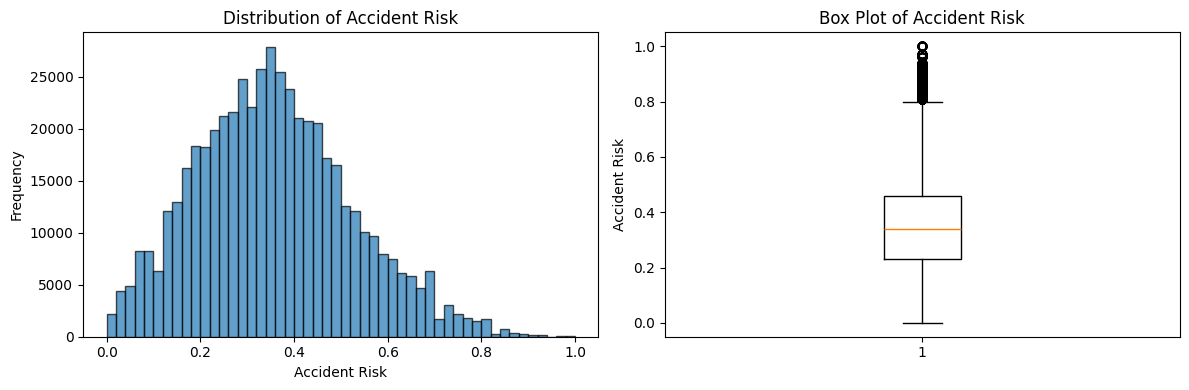

Accident Risk Statistics:
count    517754.000000
mean          0.352377
std           0.166417
min           0.000000
25%           0.230000
50%           0.340000
75%           0.460000
max           1.000000
Name: accident_risk, dtype: float64


In [10]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(train['accident_risk'], bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Accident Risk')
plt.xlabel('Accident Risk')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(train['accident_risk'])
plt.title('Box Plot of Accident Risk')
plt.ylabel('Accident Risk')

plt.tight_layout()
plt.show()

print("Accident Risk Statistics:")
print(train['accident_risk'].describe())


# Enhanced Categorical features analysis with boxplots

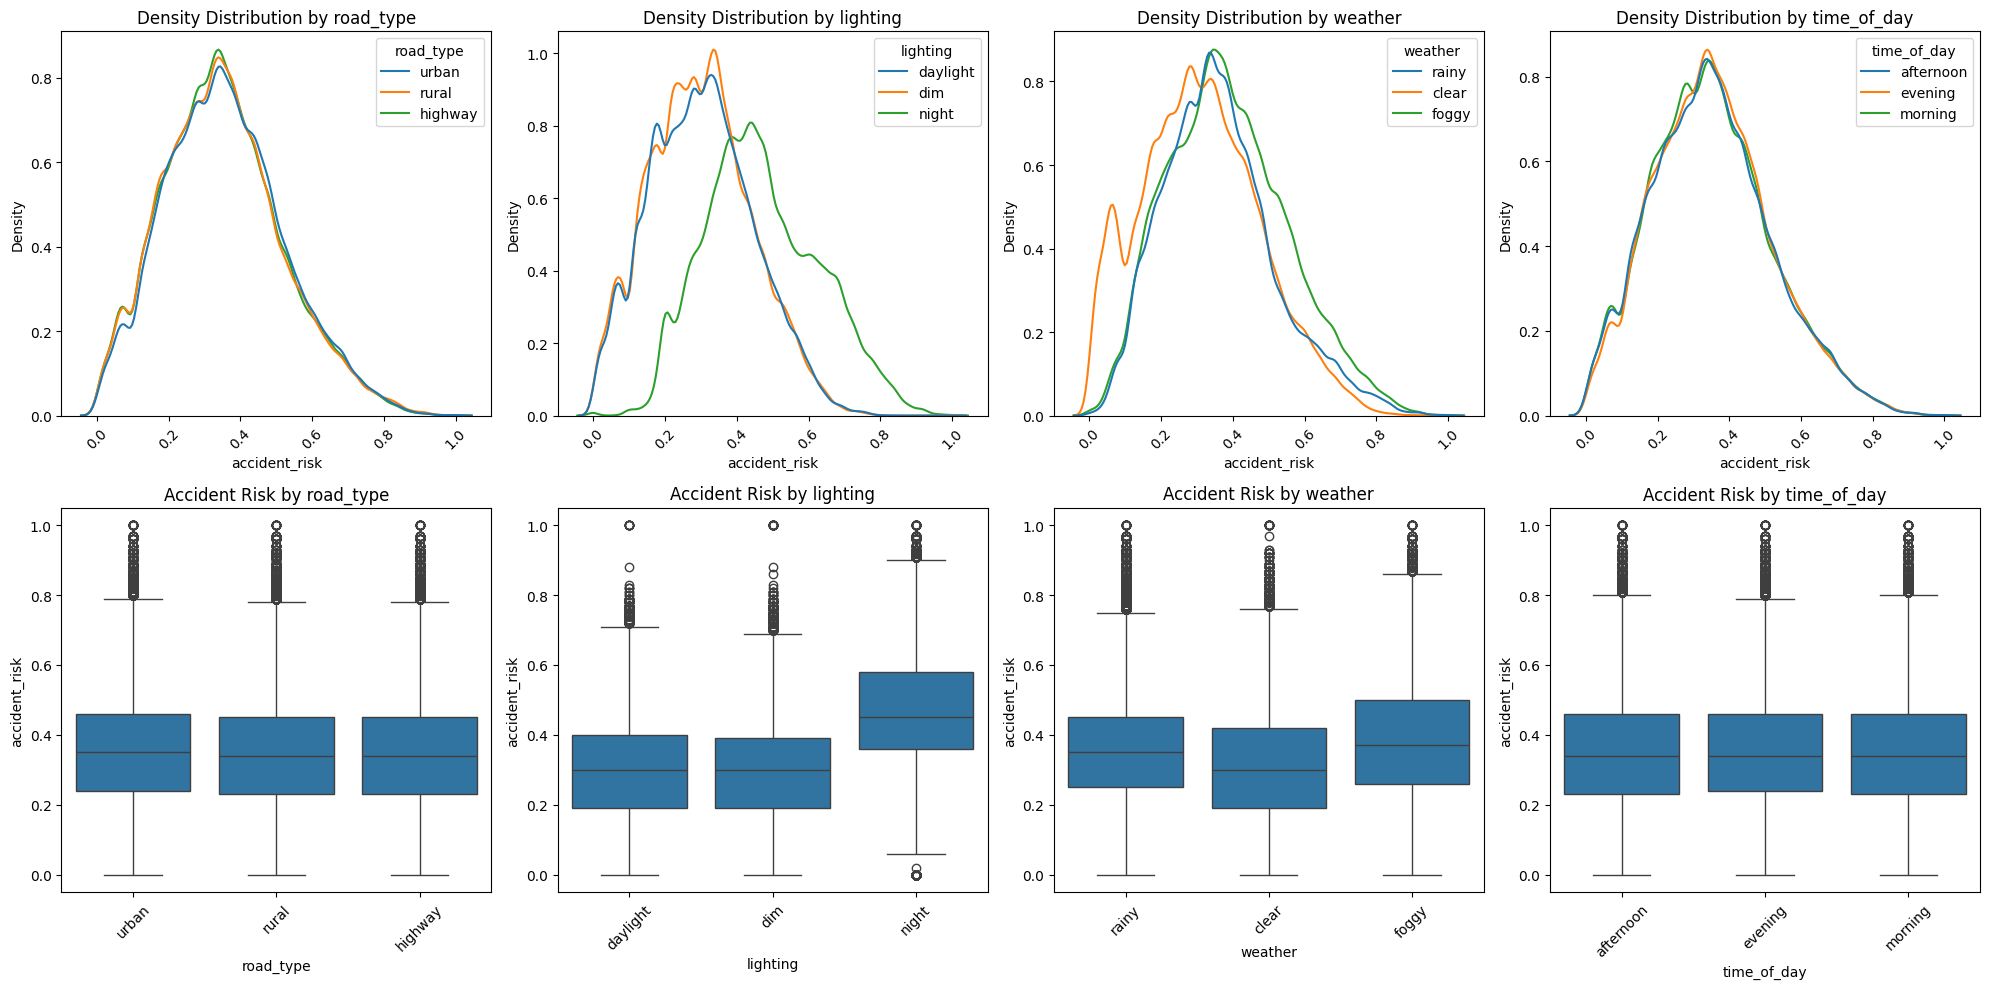

Accident Risk Summary by Categorical Features:

ROAD_TYPE:
            count    mean     std  min  max
road_type                                  
highway    173672  0.3497  0.1659  0.0  1.0
rural      172719  0.3500  0.1672  0.0  1.0
urban      171363  0.3575  0.1660  0.0  1.0

LIGHTING:
           count    mean     std  min  max
lighting                                  
daylight  178015  0.3029  0.1428  0.0  1.0
dim       183826  0.3001  0.1420  0.0  1.0
night     155913  0.4705  0.1580  0.0  1.0

WEATHER:
          count    mean     std  min  max
weather                                  
clear    179306  0.3101  0.1649  0.0  1.0
foggy    181463  0.3863  0.1676  0.0  1.0
rainy    156985  0.3615  0.1561  0.0  1.0

TIME_OF_DAY:
              count    mean     std  min  max
time_of_day                                  
afternoon    171507  0.3514  0.1675  0.0  1.0
evening      172837  0.3547  0.1645  0.0  1.0
morning      173410  0.3510  0.1672  0.0  1.0


In [11]:

categorical_features = ['road_type', 'lighting', 'weather', 'time_of_day']

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, feature in enumerate(categorical_features):
    # Density plot
    sns.kdeplot(data=train, x='accident_risk', hue=feature, ax=axes[0, i])
    axes[0, i].set_title(f'Density Distribution by {feature}')
    axes[0, i].tick_params(axis='x', rotation=45)
    
    # Box plot showing accident risk by category
    sns.boxplot(data=train, x=feature, y='accident_risk', ax=axes[1, i])
    axes[1, i].set_title(f'Accident Risk by {feature}')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics for accident risk by categorical features
print("Accident Risk Summary by Categorical Features:")
print("=" * 50)
for feature in categorical_features:
    print(f"\n{feature.upper()}:")
    summary = train.groupby(feature)['accident_risk'].agg(['count', 'mean', 'std', 'min', 'max'])
    print(summary.round(4))


In [12]:
# lighning possui correlação com o risco de acidente somente a noite
# weather possui correlação com o risco de acidente somente em dias chuvosos e em dias de nevoeiro
# time_of_day e road_type não possuem correlação com o risco de acidente diretamente

# Numerical features analysis

In [ ]:
# Fixed XGBoost parameter grid for CUDA
from sklearn.model_selection import GridSearchCV

# Corrected parameter grid - all values must be lists for GridSearchCV
param_grid = {
    'max_depth': [7],
    'learning_rate': [0.01],
    'n_estimators': [1000, 1200],
    'min_child_weight': [1],
    'device': ['cuda'],  # Fixed: wrapped in list
    'random_state': [42],  # Fixed: wrapped in list
    'enable_categorical': [True]  # Fixed: wrapped in list
}

# Initialize XGBoost model
xgb_model = XGBRegressor()

print("Training XGBoost with GridSearchCV...")
print(f"Parameter grid: {param_grid}")

# Perform grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=1,  # Use 1 job to avoid CUDA conflicts
    verbose=1
)

# Train model with grid search
grid_search.fit(X_train_encoded, y_train)

# Get best model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_val_encoded)

# Calculate metrics
mse = mean_squared_error(y_val, y_pred)
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"\nBest parameters: {grid_search.best_params_}")
print(f"MSE: {mse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"R²: {r2:.4f}")

# Store results
xgb_results = {
    'model': best_model,
    'mse': mse,
    'mae': mae,
    'r2': r2,
    'predictions': y_pred,
    'best_params': grid_search.best_params_
}


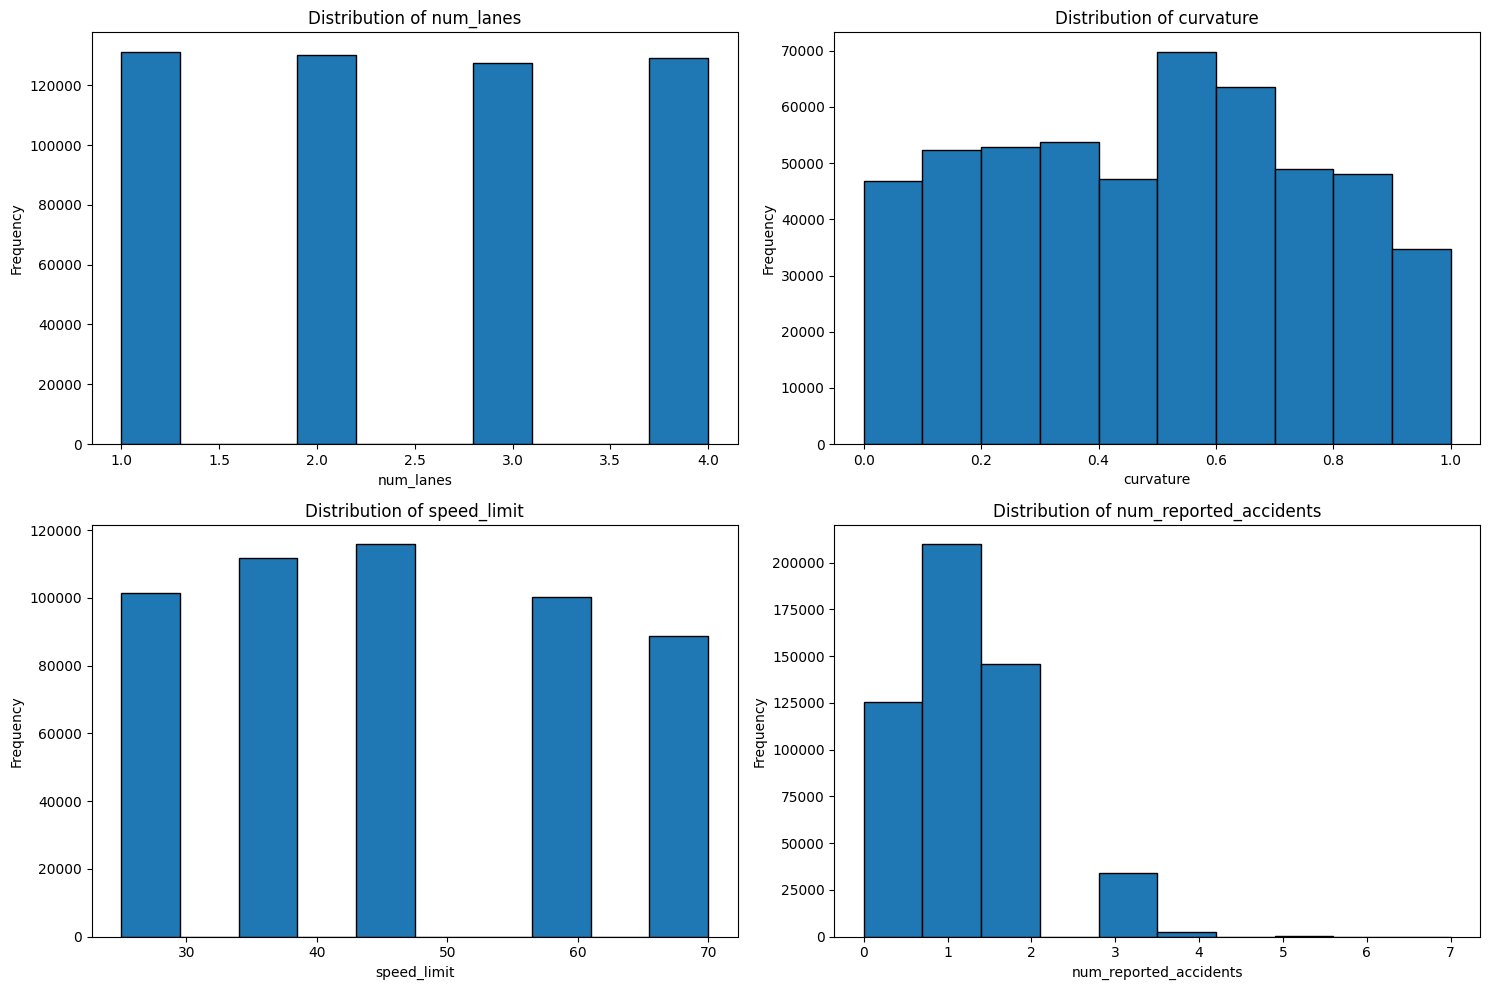

Numerical features statistics:
           num_lanes      curvature    speed_limit  num_reported_accidents
count  517754.000000  517754.000000  517754.000000           517754.000000
mean        2.491511       0.488719      46.112575                1.187970
std         1.120434       0.272563      15.788521                0.895961
min         1.000000       0.000000      25.000000                0.000000
25%         1.000000       0.260000      35.000000                1.000000
50%         2.000000       0.510000      45.000000                1.000000
75%         3.000000       0.710000      60.000000                2.000000
max         4.000000       1.000000      70.000000                7.000000


In [13]:

numerical_features = ['num_lanes', 'curvature', 'speed_limit', 'num_reported_accidents']

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(numerical_features):
    # Histogram
    axes[i].hist(train[feature], edgecolor='black')
    axes[i].set_title(f'Distribution of {feature}')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

print("Numerical features statistics:")
print(train[numerical_features].describe())


In [14]:
for feature in numerical_features:
    if feature != 'curvature':
        print(f"\n{feature.upper()}:")
        print(train[feature].unique())



NUM_LANES:
[2 4 1 3]

SPEED_LIMIT:
[35 70 60 45 25]

NUM_REPORTED_ACCIDENTS:
[1 0 2 3 4 5 6 7]


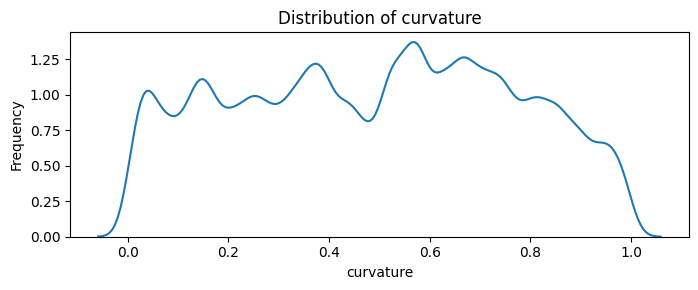

In [15]:
fig, ax = plt.subplots(1, 1, figsize=(7, 3))

# Histogram
sns.kdeplot(train['curvature'])
ax.set_title('Distribution of curvature')
ax.set_xlabel('curvature')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

C:\Users\ricar\AppData\Local\Temp\ipykernel_52744\3587032401.py:10: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=data, x='accident_risk', hue=feature, ax=axes[0, i])


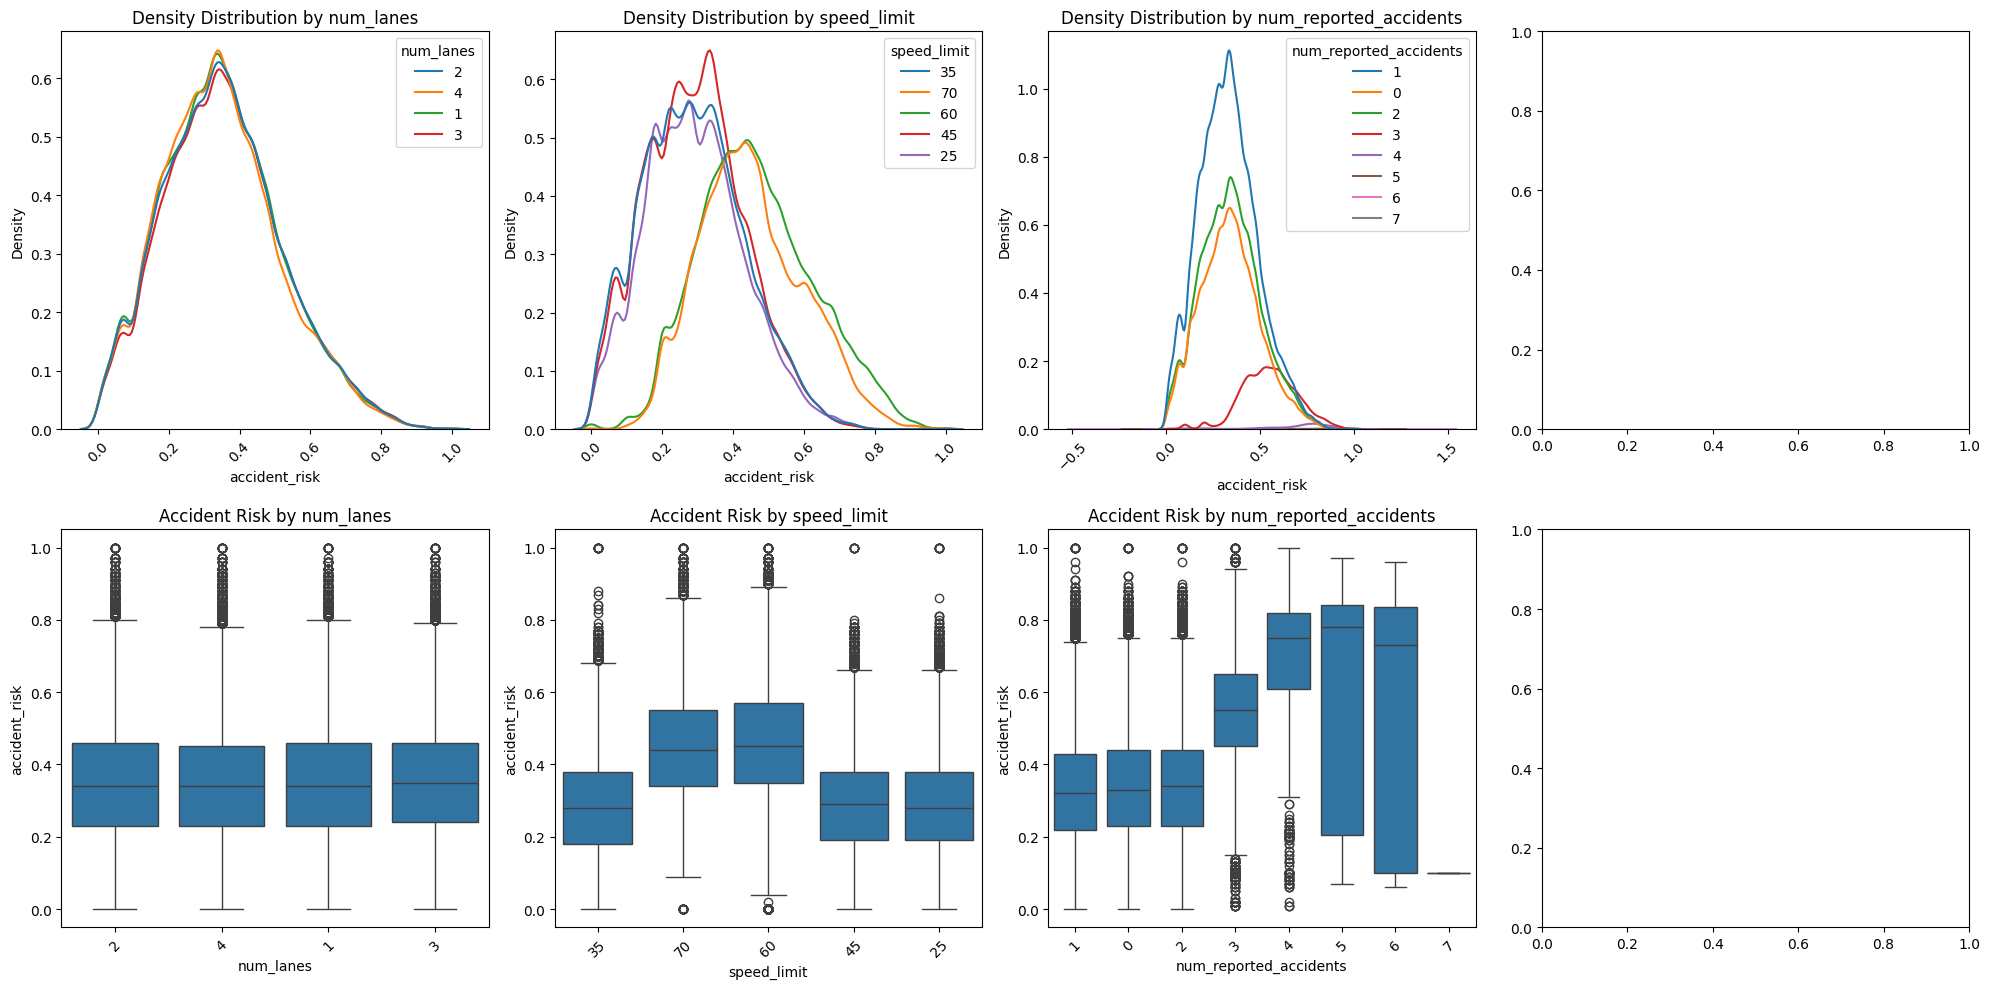

In [16]:
numerical_features = ['num_lanes', 'speed_limit', 'num_reported_accidents']

data = train.copy()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))

for i, feature in enumerate(numerical_features):
    data[feature] = data[feature].astype(str)
    # Density plot
    sns.kdeplot(data=data, x='accident_risk', hue=feature, ax=axes[0, i])
    axes[0, i].set_title(f'Density Distribution by {feature}')
    axes[0, i].tick_params(axis='x', rotation=45)
    
    # Box plot showing accident risk by category
    sns.boxplot(data=data, x=feature, y='accident_risk', ax=axes[1, i])
    axes[1, i].set_title(f'Accident Risk by {feature}')
    axes[1, i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

In [17]:
# As features num_lanes, speed_limit, num_reported_accidents possuem poucos valores únicos, que podem ser categorizados
# A feature curvature é multimodal o que sugere nao linearidade e possivelmente a necessidade de criar bins
# A feature speed_limit 70 e 60 formam um grupo enquanto 35, 45 e 25 foram outro grupo
# A feature num_reported_accidents 1, 0, 2 formam um grupo
# num_lanes parece nao ter efeito direto no risco de acidente


# Correlation analysis using Spearman correlation

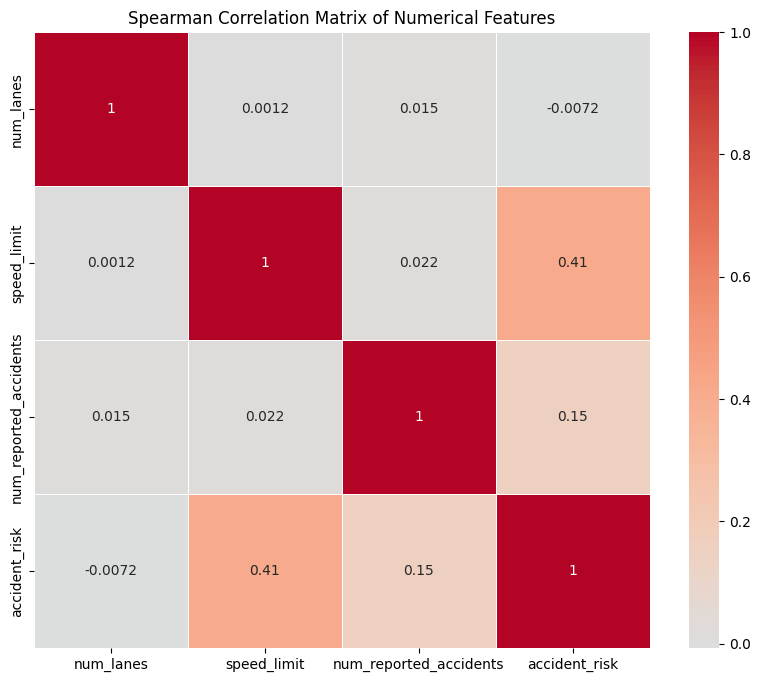

In [18]:

# Create correlation matrix for numerical features
numerical_data = train[numerical_features + ['accident_risk']]
correlation_matrix = numerical_data.corr(method='spearman')

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=0.5)
plt.title('Spearman Correlation Matrix of Numerical Features')
plt.show()


# Analyze boolean features

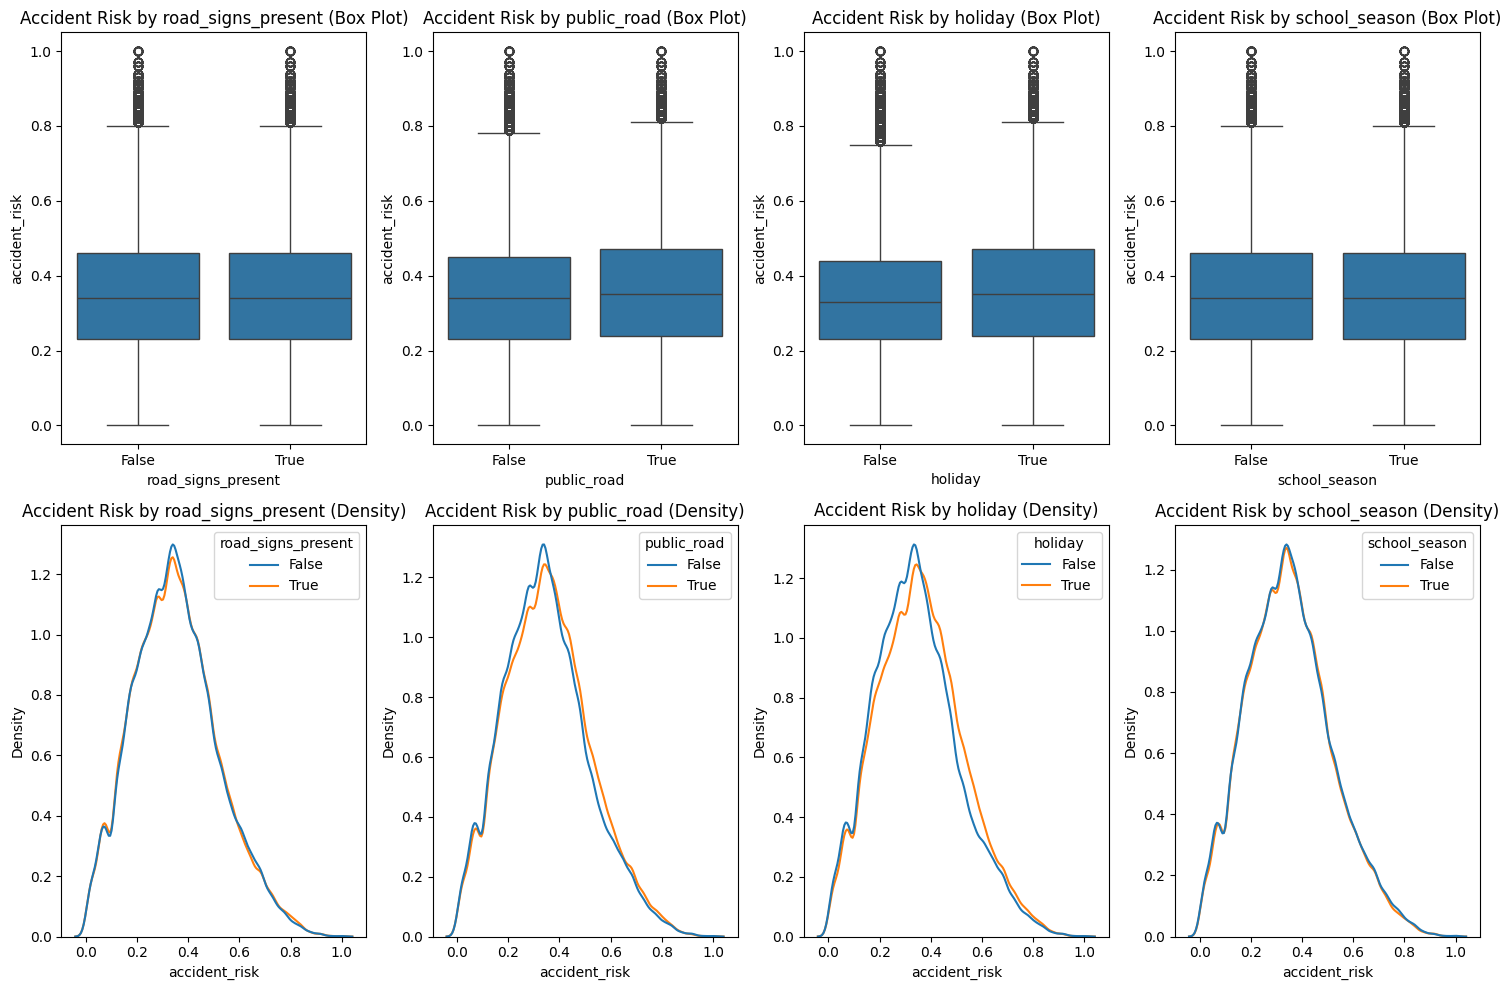

In [19]:

boolean_features = ['road_signs_present', 'public_road', 'holiday', 'school_season']

fig, axes = plt.subplots(2, 4, figsize=(15, 10))
axes = axes.ravel()

for i, feature in enumerate(boolean_features):
    # Box plot showing accident risk by boolean feature
    sns.boxplot(data=train, x=feature, y='accident_risk', ax=axes[i])
    axes[i].set_title(f'Accident Risk by {feature} (Box Plot)')
    
    # Density plot
    sns.kdeplot(data=train, x='accident_risk', hue=feature, ax=axes[i+4])
    axes[i+4].set_title(f'Accident Risk by {feature} (Density)')

plt.tight_layout()
plt.show()


# Data Preprocessing and Feature Engineering

In [ ]:
def create_features(df):
    df_new = df.copy()
    
    # Speed limit categories
    df_new.loc[df_new['speed_limit'] >= 60, 'speed_category'] = 'high'
    df_new.loc[df_new['speed_limit'] < 60, 'speed_category'] = 'low'
    df_new = df_new.drop(columns=['speed_limit'])
    
    # Curvature categories
    df_new['curvature_category'] = pd.cut(df['curvature'], 
                                         bins=[0, 0.3, 0.6, 1.0], 
                                         labels=['low', 'medium', 'high'])
    df_new = df_new.drop(columns=['curvature'])
    
    return df_new

In [33]:

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings('ignore')

# Prepare features and target
X = train.drop(['id', 'accident_risk'], axis=1)
y = train['accident_risk']
X_test = test.drop(['id'], axis=1)

print("Features shape:", X.shape)
print("Target shape:", y.shape)
print("Test features shape:", X_test.shape)


Features shape: (517754, 12)
Target shape: (517754,)
Test features shape: (172585, 12)


In [35]:
# Apply feature engineering
X_engineered = create_features(X)
X_test_engineered = create_features(X_test)

# Encode new categorical features
categorical_cols = ['road_type', 'lighting', 'weather', 'time_of_day', 'speed_category', 'curvature_category']
for col in categorical_cols:
    le = LabelEncoder()
    X_engineered[col] = le.fit_transform(X_engineered[col].astype(str))
    X_test_engineered[col] = le.transform(X_test_engineered[col].astype(str))

print("Engineered features shape:", X_engineered.shape)
print("Engineered test features shape:", X_test_engineered.shape)


Engineered features shape: (517754, 12)
Engineered test features shape: (172585, 12)


In [36]:
# Split data for validation
X_train, X_val, y_train, y_val = train_test_split(
    X_engineered, y, test_size=0.2, random_state=42, stratify=None
)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (414203, 12)
Validation set shape: (103551, 12)


In [ ]:
# Define XGBoost parameters grid
from sklearn.model_selection import GridSearchCV


param_grid = {
    'device': ['cuda'],      
    'random_state': [42],       
    'enable_categorical': [True],
    'max_depth': [7],
    'learning_rate': [0.01],
    'n_estimators': [1000]
    # 'min_child_weight': [1]
    # 'subsample': [1],
    # 'colsample_bytree': [1]
}

# Initialize models dictionary
models = {
    'XGBoost': XGBRegressor()
}

# Train and evaluate models
results = {}
for name, model in models.items():
    print(f"\nTraining {name} with GridSearchCV...")
    
    # Perform grid search
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=1,
        verbose=1
    )
    
    # Train model with grid search
    grid_search.fit(X_train, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_val)
    
    # Calculate metrics
    mse = mean_squared_error(y_val, y_pred)
    mae = mean_absolute_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    results[name] = {
        'model': best_model,
        'mse': mse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred,
        'best_params': grid_search.best_params_
    }
    
    print(f"\nBest parameters: {grid_search.best_params_}")
    print(f"MSE: {mse:.4f}")
    print(f"MAE: {mae:.4f}")
    print(f"R²: {r2:.4f}")



Training XGBoost with GridSearchCV...
Fitting 5 folds for each of 2 candidates, totalling 10 fits

Best parameters: {'device': 'cuda', 'enable_categorical': True, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 1, 'n_estimators': 1000, 'random_state': 42}
MSE: 0.0041
MAE: 0.0497
R²: 0.8507


Model Performance Comparison:
     Model       MSE       MAE        R²
0  XGBoost  0.004122  0.049743  0.850704


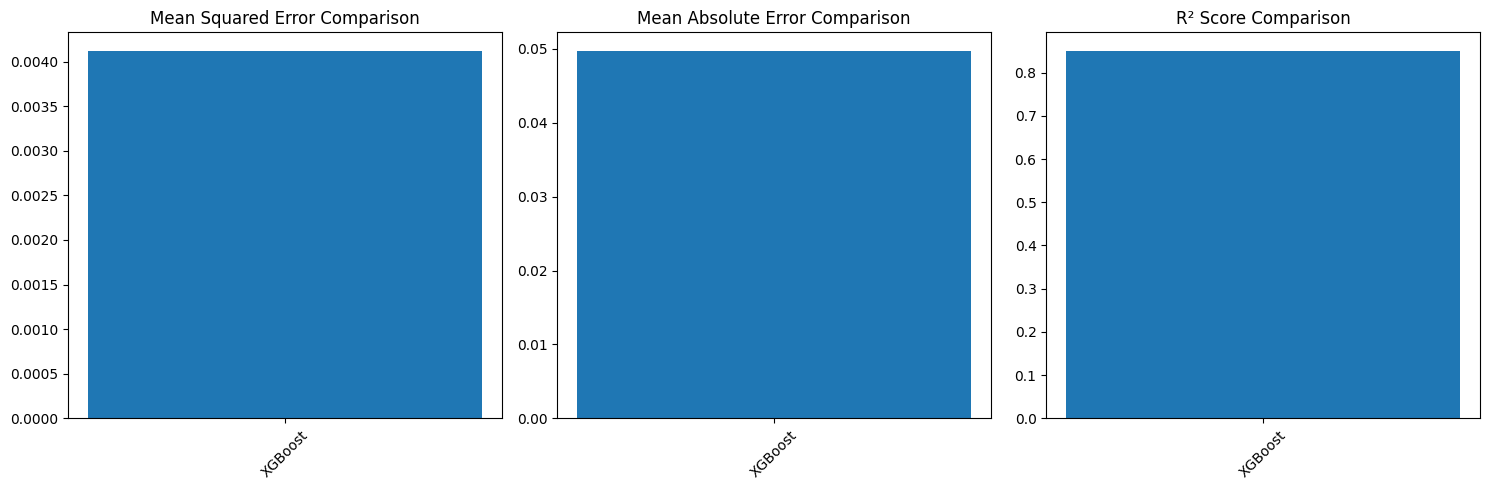

In [47]:
# Compare model performance
performance_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[name]['mse'] for name in results.keys()],
    'MAE': [results[name]['mae'] for name in results.keys()],
    'R²': [results[name]['r2'] for name in results.keys()]
})

print("Model Performance Comparison:")
print(performance_df.sort_values('R²', ascending=False))

# Visualize model performance
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# MSE comparison
axes[0].bar(performance_df['Model'], performance_df['MSE'])
axes[0].set_title('Mean Squared Error Comparison')
axes[0].tick_params(axis='x', rotation=45)

# MAE comparison
axes[1].bar(performance_df['Model'], performance_df['MAE'])
axes[1].set_title('Mean Absolute Error Comparison')
axes[1].tick_params(axis='x', rotation=45)

# R² comparison
axes[2].bar(performance_df['Model'], performance_df['R²'])
axes[2].set_title('R² Score Comparison')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


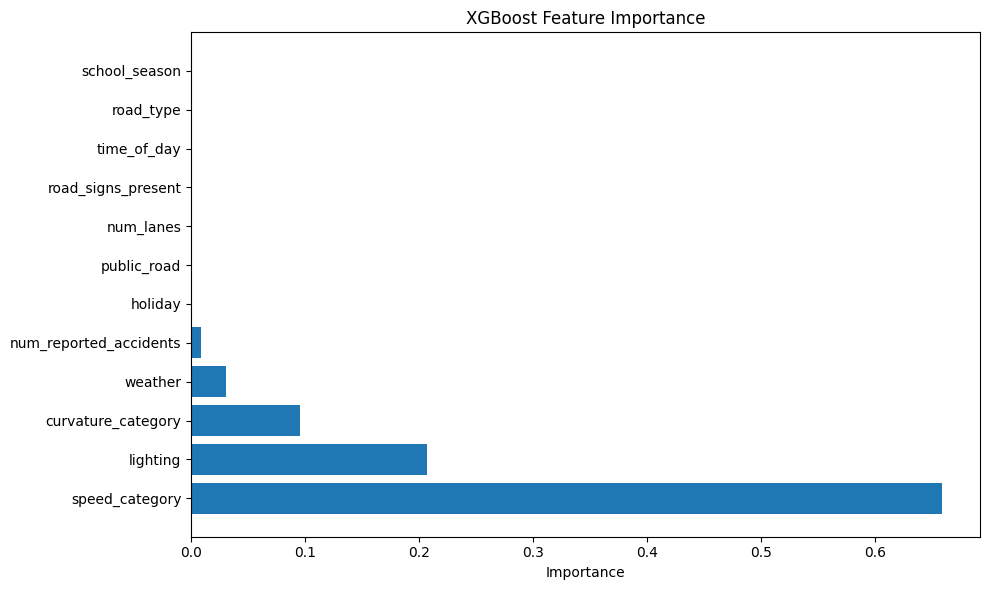

Top 10 Most Important Features (XGBoost):
                   feature  importance
10          speed_category    0.658767
2                 lighting    0.206427
11      curvature_category    0.095525
3                  weather    0.030094
9   num_reported_accidents    0.008164
7                  holiday    0.000328
5              public_road    0.000266
1                num_lanes    0.000101
4       road_signs_present    0.000100
6              time_of_day    0.000081


In [48]:
# Feature importance analysis for XGBoost model
fig, ax = plt.subplots(figsize=(10, 6))

# XGBoost feature importance
xgb_model = results['XGBoost']['model']
xgb_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

ax.barh(xgb_importance['feature'], xgb_importance['importance'])
ax.set_title('XGBoost Feature Importance')
ax.set_xlabel('Importance')

plt.tight_layout()
plt.show()

print("Top 10 Most Important Features (XGBoost):")
print(xgb_importance.head(10))


In [ ]:
# Select best model and generate predictions
best_model_name = performance_df.loc[performance_df['R²'].idxmax(), 'Model']
best_model = results[best_model_name]['model']

print(f"Best performing model: {best_model_name}")
print(f"R² Score: {results[best_model_name]['r2']:.4f}")
print(f"MSE: {results[best_model_name]['mse']:.4f}")
print(f"MAE: {results[best_model_name]['mae']:.4f}")

# Generate predictions for test set
test_predictions = best_model.predict(X_test_engineered)

print(f"\nTest predictions shape: {test_predictions.shape}")
print(f"Test predictions range: {test_predictions.min():.4f} to {test_predictions.max():.4f}")
print(f"Test predictions mean: {test_predictions.mean():.4f}")


Best performing model: XGBoost
R² Score: 0.8507
MSE: 0.0041
MAE: 0.0497

Test predictions shape: (172585,)
Test predictions range: 0.0177 to 0.8891
Test predictions mean: 0.3516


Submission file saved as 'submission.csv'

First 10 predictions:
       id  accident_risk
0  517754       0.348773
1  517755       0.151790
2  517756       0.154960
3  517757       0.321076
4  517758       0.405828
5  517759       0.439062
6  517760       0.250890
7  517761       0.158372
8  517762       0.360098
9  517763       0.282206


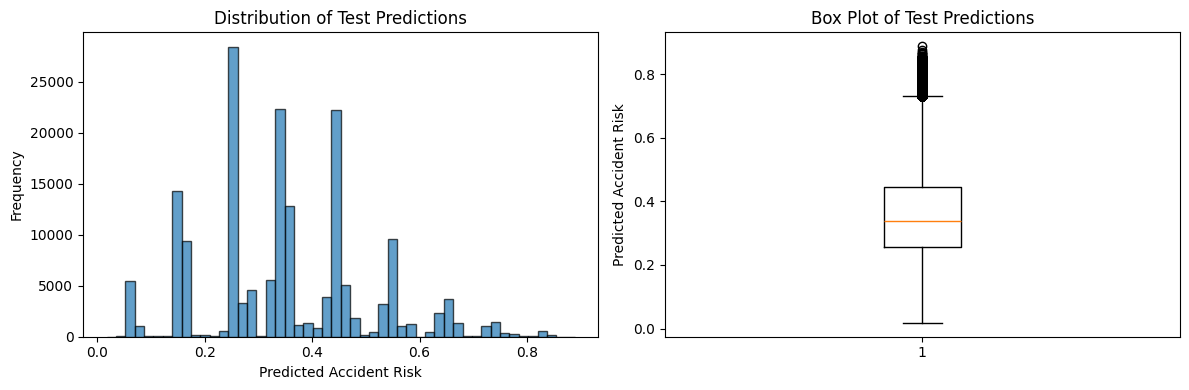


Prediction Statistics:
Mean: 0.3516
Std: 0.1538
Min: 0.0177
Max: 0.8891
25th percentile: 0.2556
50th percentile: 0.3398
75th percentile: 0.4464


In [ ]:
# Create submission file
submission_df = pd.DataFrame({
    'id': test['id'],
    'accident_risk': test_predictions
})

# Save submission
submission_df.to_csv('submission1.csv', index=False)
print("Submission file saved as 'submission.csv'")
print("\nFirst 10 predictions:")
print(submission_df.head(10))

# Analyze prediction distribution
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(test_predictions, bins=50, alpha=0.7, edgecolor='black')
plt.title('Distribution of Test Predictions')
plt.xlabel('Predicted Accident Risk')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.boxplot(test_predictions)
plt.title('Box Plot of Test Predictions')
plt.ylabel('Predicted Accident Risk')

plt.tight_layout()
plt.show()

print(f"\nPrediction Statistics:")
print(f"Mean: {test_predictions.mean():.4f}")
print(f"Std: {test_predictions.std():.4f}")
print(f"Min: {test_predictions.min():.4f}")
print(f"Max: {test_predictions.max():.4f}")
print(f"25th percentile: {np.percentile(test_predictions, 25):.4f}")
print(f"50th percentile: {np.percentile(test_predictions, 50):.4f}")
print(f"75th percentile: {np.percentile(test_predictions, 75):.4f}")
